### 0.1 Import Package

In [1]:
import os
from pyprnt import prnt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torchvision
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0")

PyTorch Version:  2.0.1+cu117
Torchvision Version:  0.15.2+cu117


In [2]:
""" User Define function """

# from model.models import Conv4

from model.pretrained_models import select_model
from dataset_dir.datasets import datasetload

from utils.util_functions import name_parser
from utils.util_functions import get_alias

from utils.visualize_tool import visualize_tensor
from utils.visualize_tool import visualize_filters
from utils.visualize_tool import visualize_feature_map
from utils.visualize_tool import visualize_weight_distribution

from utils.get_data import get_feature_from_dataset
from utils.visualize_tool import visualize_feature_distribution
from utils.util_functions import get_umap_embedding
from utils.visualize_tool import visualize_class_activation_images
from utils.visualize_grad import LayerCam
from utils.util_functions import get_info

from utils.get_data import get_performance_df
from utils.visualize_tool import plot_comparison_each_dataset
from utils.visualize_tool import plot_comparison_each_dataset_only_one
from utils.visualize_tool import plot_comparison_each_dataset_only_two
from utils.visualize_tool import visualize_gradXimage

### 0.2. Directory Setting

In [3]:
""" IMPORTANT

RECURSIVE
- if you want visualization all weight in your directory, then RECURSIVE  = TRUE
- else, you want visualization specific log in your directory, then RECURSIVE = FALSE

SAVE
- if you want save all visualization image, then SAVE = TRUE
- else, you don't want save image, then SAVE = FALSE

SHOW
- if you want visualization result in this jupyter kernel, then SHOW = TRUE
- else, you don't want show image in jupyter kernel, then SHOW = FALSE

"""

RECURSIVE = True
SAVE = True
SHOW = False

Specific model setting: 특정한 모델을 확인하기 위해

In [4]:
if not RECURSIVE :
    conf = dict(
        epoch=100,
        lr=0.001,
        stepsize=50,
        gamma=0.1,
        model="resnet18",
        dataset="cub",
        pretrain=False,
        mode="cus"
    )
    MODEL_DIR = "./model/best_weight/"
    LOG_DIR = "./results/best_log/"

    name = str(conf['model'])+"_"+str(conf['dataset'])+"_"+str(conf['mode'])
    model_path = MODEL_DIR + name +".pt"
    log_path = LOG_DIR +  name


    print(model_path)
    print(log_path)

Entire model setting: directory에 저장되어있는 전체 모델을 확인하기 위해

In [5]:
if RECURSIVE :
    MODEL_DIR = "./model/best_weight"
    LOG_DIR = "./results/best_log"

    weight_files = [os.path.join(MODEL_DIR, file) for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
    log_files = [os.path.join(LOG_DIR, file) for file in os.listdir(LOG_DIR)]

    print(len(weight_files))
    print(weight_files[0])
    print(len(log_files))
    print(log_files[0])

6
./model/best_weight/resnet50_cars_standard.pt
6
./results/best_log/resnet50_cub_standard


### 1. Architecture
특정 데이터셋, 모델의 구조를 확인하기 위한 코드. RECURSIVE하게 모든 weight파일에 대해서 동작하지 않습니다.

In [6]:
if not RECURSIVE :
    trainloader, validloader, testloader, num_class = datasetload(conf['dataset'])
    MODEL = select_model(conf['model'], num_class)
    model_state = torch.load(model_path)
    MODEL.load_state_dict(model_state)

#### 1.1 Model Architecture

In [7]:
if not RECURSIVE :
    print(MODEL)

In [8]:
if not RECURSIVE :
    summary(MODEL, (3, 224, 224), device='cpu')

*사용하고자하는 모델의 layer에 대한 정보를 기록합니다. (e.g., Alexnet)

In [9]:
# setting
CLASS_NUM = dict(
    cifar100=100,
    cub=200,
    cars=196
)

In [10]:
temp_conf = name_parser(weight_files[0])
num_class = CLASS_NUM[temp_conf['dataset']]
temp_model = select_model(temp_conf['model'], num_class)
temp_layer_names = [name for name, _ in temp_model.named_modules()]
print(temp_layer_names)

# setting
if temp_conf['model'] == 'resnet18':
    layer_name_list = ['conv1', 'layer1.0.conv2', 'layer1.1.conv2', 'layer2.0.conv2', 'layer2.1.conv2', \
                'layer3.0.conv2', 'layer3.1.conv2', 'layer4.0.conv2', 'layer4.1.conv2']
    model_info = dict(
    conv1=0, conv2=10, conv3=11, conv4=20, conv5=21, conv6=30, conv7=31, conv8=40, conv9=41)   
elif temp_conf['model'] == 'resnet50':
    layer_name_list = ['conv1', 'layer1.0.conv2', 'layer1.1.conv2', 'layer1.2.conv2', 'layer2.0.conv2', 'layer2.1.conv2', \
                'layer2.2.conv2', 'layer2.3.conv2', 'layer3.0.conv2', 'layer3.1.conv2', 'layer3.2.conv2', 'layer3.3.conv2', \
                'layer3.4.conv2', 'layer3.5.conv2', 'layer4.0.conv2', 'layer4.1.conv2', 'layer4.2.conv2']
    model_info = dict(
    conv1=0, conv2=10, conv3=11, conv4=12, conv5=20, conv6=21, conv7=22, conv8=23, conv9=30, conv10=31, conv11=32, conv12=33, conv13=34, conv14=35, conv15=40, conv16=41, conv17=42)   
else: # alexnet
    layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']
    model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10)   
print(get_alias(layer_name_list[1], model_info, model=temp_conf['model']))

['', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.relu', 'layer1.0.downsample', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.relu', 'layer1.2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.relu', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.relu', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.conv3', 'layer2.1.bn3', 'layer2.1.relu', 'layer2.2', 'layer2.2.conv1', 'layer2.2.bn1', 'layer2.2.conv2', 'layer2.2.bn2', 'layer2.2.conv3', 'layer2.2.bn3', 'layer2.2.relu', 'layer2.

#### 1.2 Dataset Property

In [11]:
if not RECURSIVE :
    print(num_class)
    print(len(trainloader.dataset))
    print(len(validloader.dataset))
    print(len(testloader.dataset))

In [12]:
if not RECURSIVE :
    img_idx = 0
    image = trainloader.dataset[img_idx][0]
    print(image.shape)

    sns.set_style("white")
    visualize_tensor(image)

#### 1.3 Train/Val Best Accuracy save

In [13]:
def get_best_accuracy(path):
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    if 'scalars' in event_acc.Tags():
        scalar_tags = event_acc.Tags()['scalars']
        
        for i, tag in enumerate(scalar_tags):
            values = event_acc.Scalars(tag)
            max_value = max(v.value for v in values)
            min_value = min(v.value for v in values)
            if tag == 'Acc/train':
                best_train_acc = max_value
            elif tag == 'Acc/val':
                best_val_acc = max_value
            elif tag == 'Loss/train':
                best_train_loss = min_value
            elif tag == 'Loss/val':
                best_val_loss = min_value
    
    return best_train_acc, best_val_acc, best_train_loss, best_val_loss

In [14]:
""" RECURSIVE : Running This!!!"""
BEST_VALUES = {}

for log_path in log_files :
    conf = name_parser(log_path)
    best_train_acc, best_val_acc, best_train_loss, best_val_loss = get_best_accuracy(log_path)
    alias = conf["dataset"]+"-"+conf["mode"]
    BEST_VALUES[alias] = {'best_train_acc': best_train_acc, 'best_val_acc': best_val_acc, 'best_train_loss': best_train_loss, 'best_val_loss': best_val_loss}

prnt(BEST_VALUES)

╭─────────────────┬──────────────────────────────╮
│cub-standard     │╭──────────────┬─────────────╮│
│                 ││best_train_acc│98.7695541381││
│                 ││              │836          ││
│                 ││best_val_acc  │65.3878250122││
│                 ││              │0703         ││
│                 ││best_train_...│0.00050658808││
│                 ││              │32262337     ││
│                 ││best_val_loss │0.01892288401││
│                 ││              │722908       ││
│                 │╰──────────────┴─────────────╯│
│cifar100-standard│╭──────────────┬─────────────╮│
│                 ││best_train_acc│99.9850006103││
│                 ││              │5156         ││
│                 ││best_val_acc  │81.3099975585││
│                 ││              │9375         ││
│                 ││best_train_...│2.58607451542││
│                 ││              │0478e-05     ││
│                 ││best_val_loss │0.00985303334││
│                 ││           

#### 1.4 Train Log Print

In [15]:
# def draw_log(path, isSave=False, overlap=True):
#     conf = name_parser(path)
#     event_acc = EventAccumulator(path)
#     event_acc.Reload()

#     if 'scalars' in event_acc.Tags():
#         scalar_tags = event_acc.Tags()['scalars']

#         if not overlap :
#             plt.figure(figsize=(13, 10))
#             sns.set()

#         for i, tag in enumerate(scalar_tags):
#             values = event_acc.Scalars(tag)
#             steps = [v.step for v in values]
#             data = [v.value for v in values]
            
#             df = pd.DataFrame({'Step': steps, tag: data})

#             plt.subplot(2, 2, i + 1)
#             sns.lineplot(x='Step', y=tag, data=df, label=conf['dataset']+"("+conf['freeze']+")" )
#             plt.xlabel('Steps')
#             plt.ylabel(tag)
#             plt.title(f'{tag} over Time')
            
#         plt.tight_layout()
#         if not overlap :
#             plt.show()

# if not RECURSIVE :
#     draw_log(log_path, SAVE)

# else :
#     plt.figure(figsize=(13, 10))
#     sns.set()
#     for log_path in log_files :
#         draw_log(log_path)
#     plt.show()

### 2. Visualization

#### 2.1. cnn Filter visualization
visualize_filters : 모델을 이루는 각각의 convolution 필터의 가중치를 시각화 합니다. (constraint: 1st channel)

In [16]:
if not RECURSIVE:
    layer_name = "features.0"
    visualize_filters(model_info, MODEL, layer_name, ncols=32, nchannel=5, showAll=False)

In [17]:
""" RECURSIVE : Running This!!!"""
if RECURSIVE:
    for weight_path in tqdm(weight_files) :
        conf = name_parser(weight_path)
        num_class = CLASS_NUM[conf['dataset']]

        MODEL = select_model(conf['model'], num_class)
        model_state = torch.load(weight_path)
        MODEL.load_state_dict(model_state)
            
        # for layer_name in layer_name_list :
        #     visualize_filters(model_info, MODEL, layer_name, conf, save=SAVE, show=SHOW, ncols=32, nchannel=5, showAll=False)

100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


#### 2.2. Feature map Visualize
visualize_feature_map : 특정 입력 이미지에 대해 모델의 각 레이어를 통과했을 때 feature_map을 시각화 합니다. (constraint: 1st feature map)

In [18]:
if not RECURSIVE :
    layer_name = 'conv2'
    input_image = torch.unsqueeze(image, 0)

    activation = {}
    visualize_feature_map(activation, MODEL, input_image, layer_name, model_info[layer_name])

In [19]:
print(MODEL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# """ RECURSIVE : Running This!!!"""

# if RECURSIVE :
#     img_idx = 0
#     img_dict = dict(
#         cifar100=None,
#         cub=None,
#         cars=None
#     )
#     for dataset in img_dict:
#         trainloader, validloader, testloader, num_class = datasetload(dataset, batch_size=64)
#         image = trainloader.dataset[img_idx][0]
#         input_image = torch.unsqueeze(image, 0)
#         img_dict[dataset] = input_image
#     for weight_path in weight_files :
#         conf = name_parser(weight_path)        
#         input_image = img_dict[conf['dataset']]
#         MODEL = select_model(conf['model'], CLASS_NUM[conf['dataset']])
#         model_state = torch.load(weight_path)
#         MODEL.load_state_dict(model_state)
#         MODEL.eval()
#         # for layer_name in layer_name_list:
#         #     activation = {}
#         #     visualize_feature_map(activation, MODEL, input_image, layer_name, conf, save=SAVE, show=SHOW)

#### 2.3. weight distribution (each layer)
visualize_weight_distribution : 모델을 이루는 각각의 레이어의 가중치 분포를 시각화 합니다.

In [21]:
if not RECURSIVE :
    visualize_weight_distribution(MODEL, violin_sample=5000)

In [22]:
# """ RECURSIVE : Running This!!!"""
# if RECURSIVE :
#     for weight_path in weight_files :
#         conf = name_parser(weight_path)
#         num_class = CLASS_NUM[conf['dataset']]
        
#         MODEL = select_model(conf['model'], num_class)
#         model_state = torch.load(weight_path)
#         MODEL.load_state_dict(model_state)
        
#         # visualize_weight_distribution(MODEL, conf, save=SAVE, show=SHOW, violin_sample=3000)

#### 2.4. Dataset Distribution
visualize_feature_distribution: 모델이 판단하는 CLASS와 실제 정답 CLASS의 분포를 비교합니다.

In [23]:
if not RECURSIVE : 
    features, labels, preds = get_feature_from_dataset(MODEL, 1000, testloader, layer_name, model_info[layer_name])
    # print(features.shape)
    # print(labels.shape)
    # print(preds.shape)

    embedding = get_umap_embedding(features)
    #print(embedding.shape)
    
    visualize_feature_distribution(embedding, labels, preds, conf, layer_name, show=SHOW, save=SAVE)

In [24]:
# """ RECURSIVE : Running This!!! """ # LAST #TODO
# if RECURSIVE :
#     for weight_path in weight_files :
#         conf = name_parser(weight_path)
#         trainloader, validloader, testloader, num_class = datasetload(conf['dataset'], batch_size=64)
#         MODEL = select_model(conf['model'], num_class)
#         model_state = torch.load(weight_path)
#         MODEL.load_state_dict(model_state)
        
        # for layer_name in layer_name_list: 
        #     features, labels, preds = get_feature_from_dataset(MODEL, 1000, testloader, layer_name)
        #     embedding = get_umap_embedding(features)
        #     visualize_feature_distribution(embedding, labels, preds, conf, layer_name, num_class=7, show=SHOW, save=SAVE)

#### 2.5. Gradient
##### 2.5.1 Layer-CAM
LayerCAM [16] is a simple modification of Grad-CAM [3], which can generate reliable class activation maps from different layers.
visualize_class_activation_images: 모델이 이미지를 분류할 떄, 어떤 부분에 집중하여 판단하는지를 함께 표현하여 시각화합니다.

In [25]:
if not RECURSIVE:
    data =  trainloader.dataset[img_idx]
    origin_img, prep_img, target_class = get_info(data)
    layer_number = 12  # [0, 12]

    layer_cam = LayerCam(MODEL, layer_number)
    cam = layer_cam.generate_cam(prep_img, target_class)
    visualize_class_activation_images(origin_img, cam, conf, layer_number)

    sns.set_style("white")
    visualize_tensor(data[0])

In [28]:
# """ RECURSIVE : Running This!!! """ #TODO
# if RECURSIVE :
#     img_idx = 0
#     img_dict = dict(
#         cifar100=None,
#         cub=None,
#         cars=None
#     )
#     for dataset in img_dict:
#         trainloader, validloader, testloader, num_class = datasetload(dataset, batch_size=64)
#         data = trainloader.dataset[img_idx]
#         img_dict[dataset] = data
#     for weight_path in weight_files :
#         conf = name_parser(weight_path)        
#         data = img_dict[conf['dataset']]
#         origin_img, prep_img, target_class = get_info(data)
#         MODEL = select_model(conf['model'], CLASS_NUM[conf['dataset']])
#         model_state = torch.load(weight_path)
#         MODEL.load_state_dict(model_state)
#         MODEL.eval()
#         for idx, layer in enumerate(layer_name_list):
#             layer_cam = LayerCam(MODEL, layer)
#             cam = layer_cam.generate_cam(prep_img, target_class)
#             visualize_class_activation_images(origin_img, cam, conf, idx, show=SHOW, save=SAVE)

##### 2.5.2 Grad Times Image
Another technique that is proposed is simply multiplying the gradients with the image itself.
visualize_gradXimage: 모델이 주어진 이미지를 볼 때, 계산된 Gradient와 원본이미지의 곱으로 나타낸 그림을 시각화합니다.

In [29]:
if not RECURSIVE:
    data =  trainloader.dataset[img_idx]
    origin_img, prep_img, target_class = get_info(data)

    visualize_gradXimage(prep_img, target_class, MODEL, conf, show=SHOW, save=SAVE)

In [30]:
# """ RECURSIVE : Running This!!! """ #TODO
# if RECURSIVE :
#     img_idx = 0
#     img_dict = dict(
#         cifar100=None,
#         cub=None,
#         cars=None
#     )
#     for dataset in img_dict:
#         trainloader, validloader, testloader, num_class = datasetload(dataset, batch_size=64)
#         data = trainloader.dataset[img_idx]
#         img_dict[dataset] = data
#     for weight_path in weight_files :
#         conf = name_parser(weight_path)        
#         data = img_dict[conf['dataset']]
#         origin_img, prep_img, target_class = get_info(data)

#         MODEL = select_model(conf['model'], CLASS_NUM[conf['dataset']])
#         model_state = torch.load(weight_path)
#         MODEL.load_state_dict(model_state)
#         MODEL.eval()

#         visualize_gradXimage(prep_img, target_class, MODEL, conf, show=SHOW, save=SAVE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Plot saved to ./results/figure/standard/resnet50/cars/GradXImage/vanila_grad.png
Plot saved to ./results/figure/standard/resnet50/cub/GradXImage/vanila_grad.png
Plot saved to ./results/figure/GBweva/resnet50/cars/GradXImage/vanila_grad.png
Plot saved to ./results/figure/GBweva/resnet50/cub/GradXImage/vanila_grad.png
Plot saved to ./results/figure/standard/resnet50/cifar100/GradXImage/vanila_grad.png
Plot saved to ./results/figure/GBweva/resnet50/cifar100/GradXImage/vanila_grad.png


### 3. Comparison
[!attention] 아래의 그래프를 그리기 전에, 반드시 1.3.을 사용하여 accuracy결과를 저장해야합니다.

In [34]:
df_dataset, df_freezing = get_performance_df(BEST_VALUES)

# for group_key, df in df_dataset.items():
#     print(f"Group: {group_key}")
#     print(df)
#     print()
# for group_key, df in df_freezing.items():
#     print(f"Group: {group_key}")
#     print(df)
#     print()

# print("01100 freezing 설정을 사용하여 cifar100 데이터셋으로 파인튜닝한 모델의 값에 접근")
# group_df = df_dataset['cifar100']
# print(group_df.loc['best_train_acc', '01100'])
# group_df = df_freezing['01100']
# print(group_df.loc['best_train_acc', 'cifar100'])

#### 3.1. Accuracy / Loss (general)
plot_comparison_each_dataset: 각 데이터셋 마다 layer-freezing 변화에 따른 accuracy, loss를 비교합니다.

In [35]:
if not RECURSIVE:
    plot_comparison_each_dataset(df_dataset)

KeyError: 'cifar10'

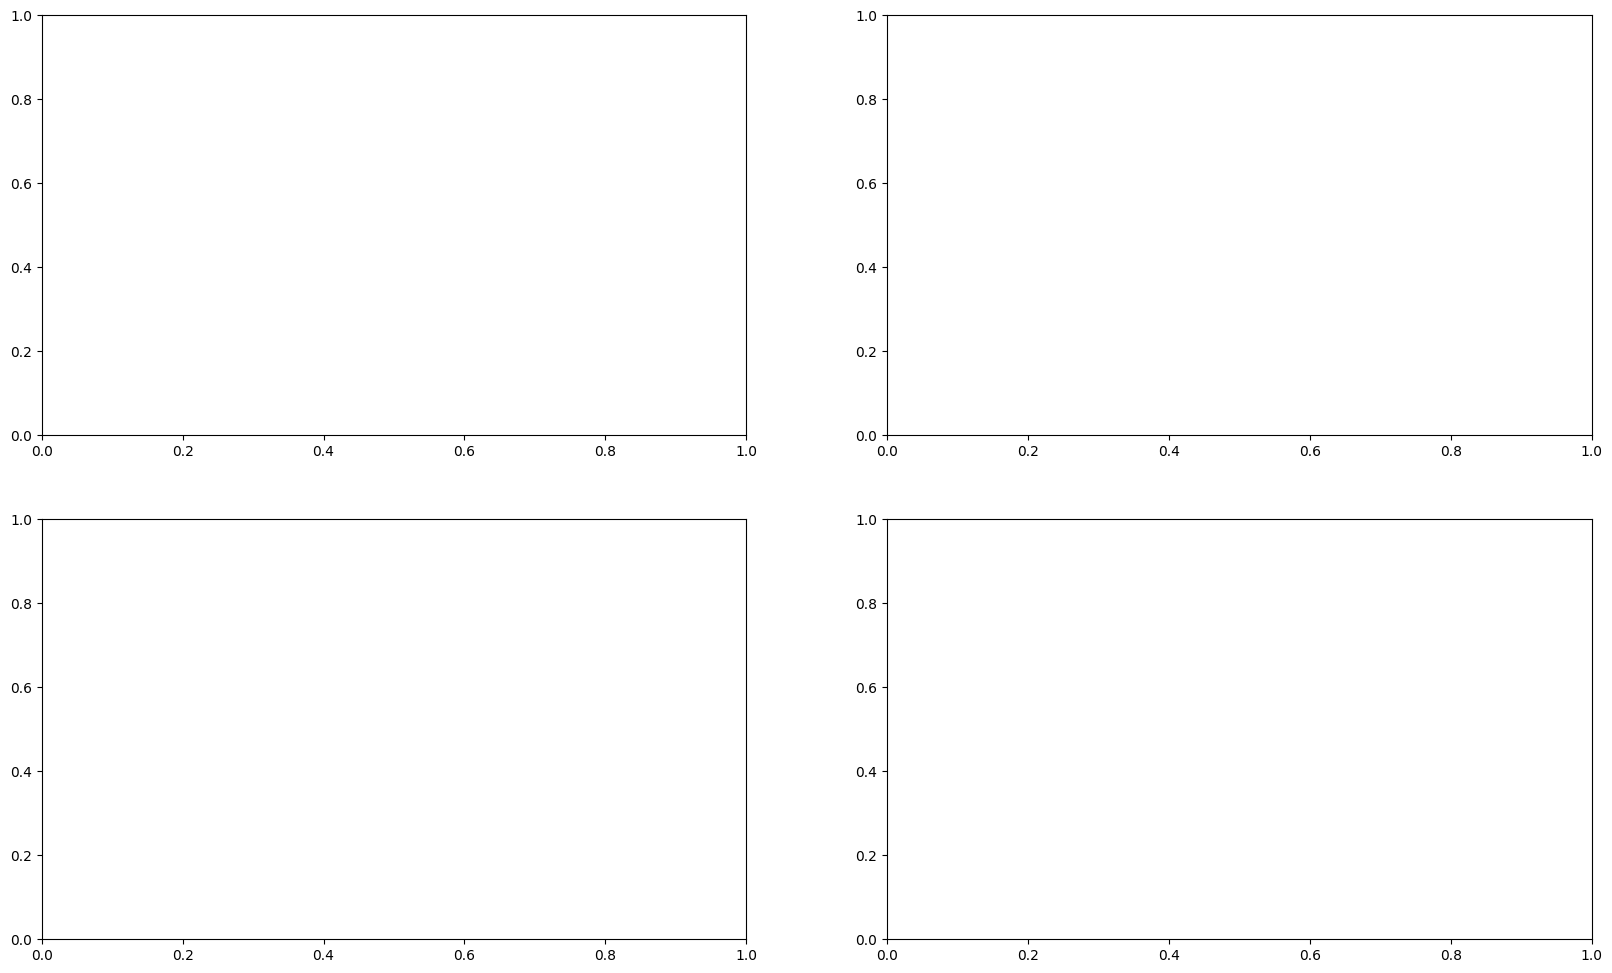

In [36]:
""" RECURSIVE SAVE : Running This!!! """
if RECURSIVE:
    plot_comparison_each_dataset(df_dataset, show=SHOW, save=SAVE)

#### 3.2. Accuracy / Loss (one-layer)
plot_comparison_each_dataset_only_one: 각 데이터셋 마다 단 하나의 layer만을 선택하여 학습한 경우 acc / loss를 그립니다.

In [ ]:
if not RECURSIVE:
    plot_comparison_each_dataset_only_one(df_dataset)

In [ ]:
""" RECURSIVE SAVE : Running This!!! """
if RECURSIVE:
    plot_comparison_each_dataset_only_one(df_dataset, show=SHOW, save=SAVE)

#### 3.3. Accuracy / Loss (two-layer)
plot_comparison_each_dataset_only_two: 각 데이터셋 마다 2개의 layer만을 선택하여 학습한 경우 acc / loss를 그립니다.

In [ ]:
if not RECURSIVE:
    plot_comparison_each_dataset_only_two(df_dataset)

In [ ]:
""" RECURSIVE SAVE : Running This!!! """
if RECURSIVE:
    plot_comparison_each_dataset_only_two(df_dataset, show=SHOW, save=SAVE)